# Black Litterman with Investor Views Optimization: Oldest Country ETFs

## 1. Data Fetching

### 1.1 Model configuration

In [1]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_sim_view',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20091231',
               'halflife': 65,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 1700,
               'process': 'none',
               'data_dir': '/Users/razvan/PyRepo/research_masc/data_store/hmm/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'SS',
                     'sampling_freq' : 'monthly',
                     'train_days': 360}
              }
         }

/Users/razvan/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### 1.2 Fetch return data

In [2]:
# Fetch returns / volumes
ss = am.SingleStockBLEWM(config)
ss.train(force=True)

# Realized Data for Simulation
prices = ss.get('prices', 'realized', ss.cfg['returns']['sampling_freq']).iloc[1:,:]
returns = ss.get('returns', 'realized', ss.cfg['returns']['sampling_freq'])
volumes = ss.get('volumes', 'realized', ss.cfg['returns']['sampling_freq'])
sigmas = ss.get('sigmas', 'realized', ss.cfg['returns']['sampling_freq'])

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key=ss.risk_free_symbol)

downloading SPY from 19970102 to 20091231
downloading EWA from 19970102 to 20091231
downloading EWC from 19970102 to 20091231
downloading EWG from 19970102 to 20091231
downloading EWH from 19970102 to 20091231
downloading EWJ from 19970102 to 20091231
downloading EWS from 19970102 to 20091231
downloading EWU from 19970102 to 20091231
downloading EWW from 19970102 to 20091231
downloading USDOLLAR from 19970102 to 20091231
Removing these days from dataset:
            nan price
1999-04-02          9
2001-09-13          9
2001-09-14          9
2007-01-02          9
2007-04-06          9
          remaining nan price
SPY                         0
EWA                         0
EWC                         0
EWG                         0
EWH                         0
EWJ                         0
EWS                         0
EWU                         0
EWW                         0
USDOLLAR                   25
Proceeding with forward fills to remove remaining NaNs


## 2. Model fitting

### 2.1 Extract Black Litterman equilibrium returns

In [3]:
# Aggregate market stats for cal
market_stats = pd.DataFrame({'MarketCap/GDP': [1.25, 1, 1.25, 0.45, 3.5, 0.8, 2, 1.25, 0.3, 0],
                             'GDP': [2543500, 150000, 239000, 853000, 22500, 1037500, 10000, 422500, 164500, 0]},
                            index=ss.universe + ['USDOLLAR'])
market_stats.loc[:, 'MarketCap'] = market_stats.loc[:, 'MarketCap/GDP'] * market_stats.loc[:, 'GDP']
market_stats.loc[:, 'MarketCap Weights'] = market_stats.loc[:, 'MarketCap'] / market_stats.loc[:, 'MarketCap'].sum()
market_stats

,MarketCap/GDP,GDP,MarketCap,MarketCap Weights
SPY,1.25,2543500,3179375.0,0.576162
EWA,1.00,150000,150000.0,0.027183
EWC,1.25,239000,298750.0,0.054139
EWG,0.45,853000,383850.0,0.069561
EWH,3.50,22500,78750.0,0.014271
EWJ,0.80,1037500,830000.0,0.150411
EWS,2.00,10000,20000.0,0.003624
EWU,1.25,422500,528125.0,0.095706
EWW,0.30,164500,49350.0,0.008943
USDOLLAR,0.00,0,0.0,0.000000


In [4]:
# Generate market cap weights pandas.Series
w_mktcap = pd.Series(index=market_stats.index, data=market_stats.loc[:, 'MarketCap Weights'])
w_mktcap['USDOLLAR'] = 0.

### 2.2 Generate BL posterior returns/covariance

def predict(self, args below):
    
        Prediction function for model, for out of sample historical test set

        :param w_market_cap_init: market cap weights at beginning of training period
        :param risk_aversion: delta (δ) - risk aversion parameter (scalar)
        :param P_view: KxN matrix for views (P * miu = Q + Epsilon)
        :param Q_view: K vector of view constants
        :param view_noise: K vector of view noise
        :param noise_mode:
                pass_through: direct
                diag: diagonalize
        :param c: certainty weight (in investor views) (scalar)
                0: complete certainty, use only investor views
                1: complete uncertainty, ignore investor views
        :return: n/a (all data stored in self.predicted)


In [115]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

risk_aversion = 2.5
confidence = 0.8
vconf = 0.9
gamma_risk = 2.5
gamma_trade = 1
gamma_hold = 1

# Predicted Data for Optimization
# US underperforms Germany 4% per year - correct view
ss.predict(w_market_cap_init=w_mktcap, risk_aversion=risk_aversion, c=confidence,
           P_view=np.array([-1, 0, 0, 1, 0, 0, 0, 0, 0, 0]), Q_view=np.array(0.04 / 252),
           view_confidence=vconf
          )

# Black Litterman output
r_pred = ss.get('returns', 'predicted')
covariance_pred = ss.get('covariance', 'predicted')
volumes_pred = ss.get('volumes', 'predicted')
sigmas_pred = ss.get('sigmas', 'predicted')

Typical variance of returns: 0.000319834


In [117]:
r_pred

,SPY,EWA,EWC,EWG,EWH,EWJ,EWS,EWU,EWW,USDOLLAR
1997-01-09,-0.000050,0.000096,-0.000052,0.000103,0.000120,0.000294,0.000105,0.000174,0.000218,1.167574e-08
1997-01-10,-0.000083,0.000080,-0.000016,0.000070,0.000125,0.000282,0.000094,0.000159,0.000285,1.130335e-08
1997-01-13,-0.000108,0.000063,-0.000017,0.000045,0.000117,0.000324,0.000088,0.000177,0.000265,8.223908e-09
1997-01-14,-0.000119,0.000073,-0.000025,0.000035,0.000125,0.000404,0.000060,0.000163,0.000202,9.002276e-09
1997-01-15,-0.000103,0.000069,-0.000017,0.000051,0.000106,0.000429,0.000047,0.000187,0.000269,1.109988e-08
...,...,...,...,...,...,...,...,...,...,...
2009-12-24,0.000575,0.000807,0.000720,0.000735,0.000648,0.000489,0.000656,0.000679,0.000746,-1.814466e-08
2009-12-28,0.000570,0.000802,0.000714,0.000731,0.000642,0.000486,0.000651,0.000674,0.000740,-1.853892e-08
2009-12-29,0.000565,0.000796,0.000708,0.000725,0.000637,0.000482,0.000645,0.000668,0.000734,-1.834006e-08
2009-12-30,0.000560,0.000789,0.000703,0.000720,0.000631,0.000478,0.000640,0.000663,0.000728,-1.803012e-08


## 3. Simulation Results

### Input Data

In [81]:
# Start and end date
# start_date = dt.datetime.strptime(config['model']['start_date'], '%Y%m%d') + \
#                 dt.timedelta(days=config['model']['train_len']*1.75)
start_date = dt.datetime(2005, 1, 2)
end_date = dt.datetime.strptime(config['model']['end_date'], '%Y%m%d')
# end_date = dt.datetime(2000, 12, 31)

# Predicted costs
optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1.,
                                   sigma=sigmas_pred,
                                   volume=volumes_pred)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

# Covariance setup
bl_risk_model = cp.FullSigma(covariance_pred)
#ff_risk_model = cp.FullSigma(covariance_hmm)

## 3.1 Weighting Schemes for Allocation

### 3.1.1 Equal Weights Simulation

Rebalance weekly back to equal weighting given drift.

In [22]:
%%time

# Equal weighting
w_equal = pd.Series(index=returns.columns, data=[1] * len(returns.columns))
w_equal['USDOLLAR'] = 0.
w_equal = w_equal / sum(w_equal)
equal_rebalance = cp.PeriodicRebalance(target=w_equal, trading_freq="week")

# Backtest
equal_w = simulator.run_multiple_backtest(1E6*w_equal,
                                          start_time=start_date,  end_time=end_date,
                                          policies=[equal_rebalance],
                                          loglevel=logging.WARNING, parallel=True)
equal_w[0].summary()

Number of periods                              1223
Initial timestamp               2005-02-24 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                         12.012
Excess return (%)                             9.241
Excess risk (%)                              28.486
Sharpe ratio                                  0.325
Max. drawdown                                60.283
Turnover (%)                                 67.280
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 44.5 ms, sys: 23.5 ms, total: 68 ms
Wall time: 19.7 s


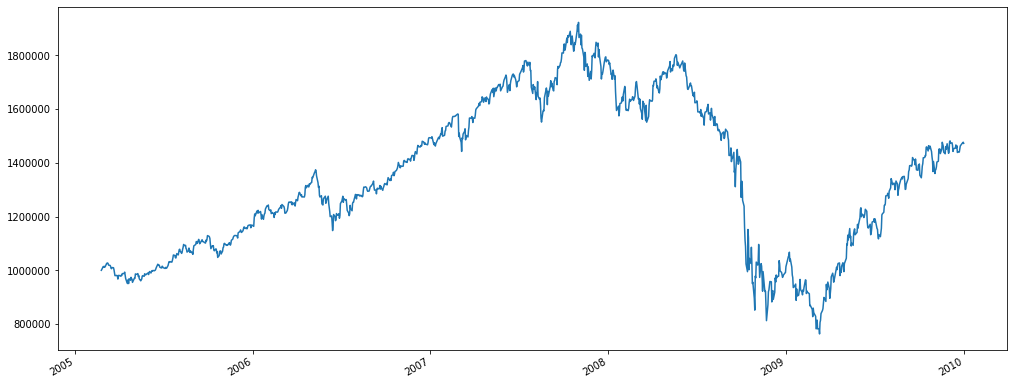

In [23]:
equal_w[0].v.plot(figsize=(17,7))

In [24]:
equal_w[0].profit

472123.553956222

### 3.1.2 Market Capitalization Weights Simulation

No rebalance needed given the weights will remain market capitalization weighted.

In [84]:
%%time

# Market cap weights
mktcap_rebalance = cp.Hold(trading_freq="year")

# Backtest
market_cap_w = simulator.run_multiple_backtest(1E6*w_mktcap,
                                               start_time=start_date,  end_time=end_date,
                                               policies=[mktcap_rebalance],
                                               loglevel=logging.WARNING, parallel=True)
market_cap_w[0].summary()

Number of periods                              1223
Initial timestamp               2005-02-24 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          5.553
Excess return (%)                             2.782
Excess risk (%)                              25.237
Sharpe ratio                                  0.110
Max. drawdown                                57.032
Turnover (%)                                  0.000
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 45.5 ms, sys: 35.2 ms, total: 80.6 ms
Wall time: 19.6 s


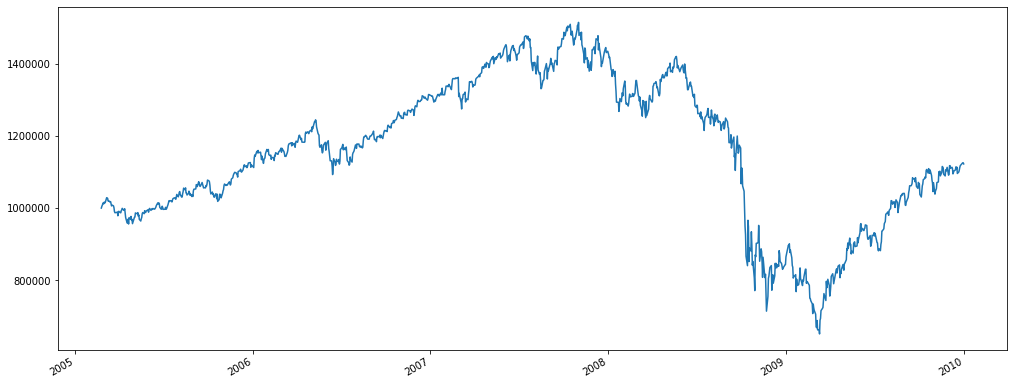

In [85]:
market_cap_w[0].v.plot(figsize=(17,7))

In [86]:
market_cap_w[0].profit

122440.00810913637

### 3.1.3 Rank and Pick Top Longs Simulation

Pick top 3 symbols at each allowed rebalance, reduce the rest

In [118]:
%%time

# Rank Long and Short policy
rank_longshort = cp.RankAndLongShort(return_forecast=r_pred,
                                     num_long=3, num_short=3,
                                     target_turnover=0.05,
                                     trading_freq='day')

# Backtest
rls_results = simulator.run_multiple_backtest(1E6*w_mktcap,
                                              start_time=start_date,  end_time=end_date,
                                              policies=[rank_longshort],
                                              loglevel=logging.WARNING, parallel=True)
rls_results[0].summary()

Number of periods                              1259
Initial timestamp               2005-01-03 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          6.973
Excess return (%)                             4.211
Excess risk (%)                               9.040
Sharpe ratio                                  0.466
Max. drawdown                                20.046
Turnover (%)                                208.667
Average policy time (sec)                     0.003
Average simulator time (sec)                  0.004
CPU times: user 63.5 ms, sys: 41 ms, total: 104 ms
Wall time: 24.6 s


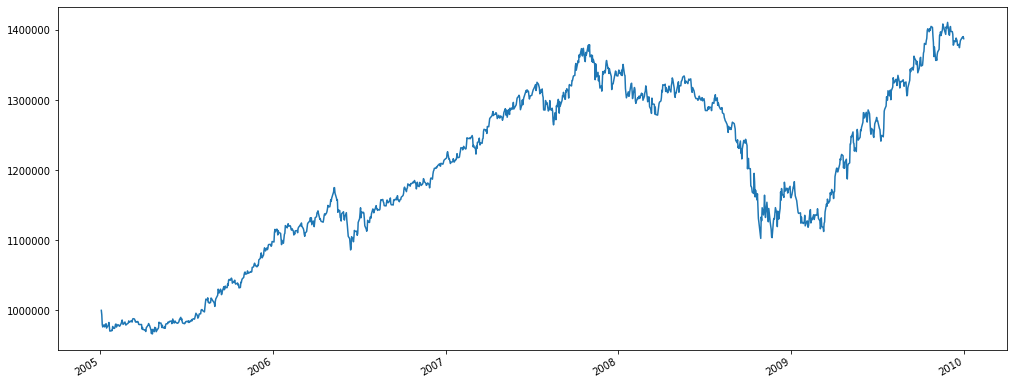

In [119]:
rls_results[0].v.plot(figsize=(17,7))

In [120]:
rls_results[0].profit

387707.22260952846

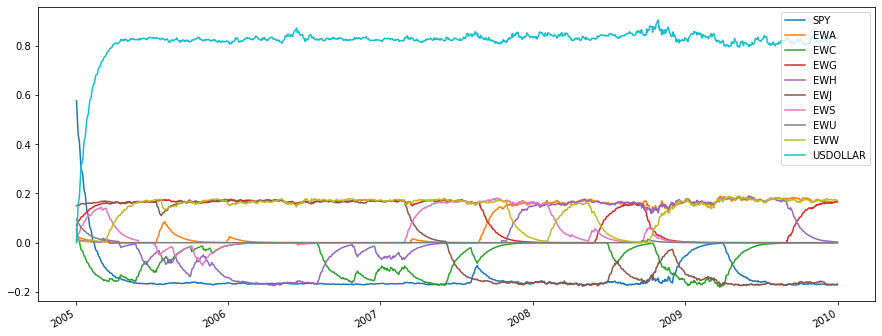

In [121]:
rls_results[0].w.plot(figsize=(15,6))

## 3.2 Single Period Optimization for Allocation

### 3.2.1 Black Litterman Unconstrained Weights Simulation

Due to the absence of trading costs, the unconstrained version of Black Litterman optimization will significantly overtrade if quantitatively driven views are introduced. One or more of the following need to be implemented in order to make it an investable strategy:
- the investor views need to be reduced in strength (tau or c parameter)
- the turnover needs to be capped
- rebalancing reduced to a longer frequency

We will not be simulating optimizations that ignore trading costs given their impractical nature with more frequent rebalances.

### 3.2.2 Black Litterman Returns & Covariance Simulation

max BL return + BL covariance + trading cost + holding cost

In [106]:
%%time

# Optimization parameters
gamma_risk, gamma_trade, gamma_hold = 0.1, 0.1, 0.
leverage_limit = cp.LeverageLimit(1)
fully_invested = cp.ZeroCash()
long_only = cp.LongOnly()

# Optimization policy
bl_spo_policy = cp.SinglePeriodOpt(return_forecast=r_pred, 
                                costs=[gamma_risk*bl_risk_model,
                                       gamma_trade*optimization_tcost,
                                       gamma_hold*optimization_hcost],
                                constraints=[leverage_limit, fully_invested, long_only],
                                trading_freq='once')

# Backtest
bl_spo_results = simulator.run_multiple_backtest(1E6*w_mktcap,
                                           start_time=start_date,  end_time=end_date,
                                           policies=[bl_spo_policy],
                                           loglevel=logging.WARNING, parallel=True)
bl_spo_results[0].summary()

Number of periods                              1259
Initial timestamp               2005-01-03 00:00:00
Final timestamp                 2009-12-31 00:00:00
Portfolio return (%)                          4.763
Excess return (%)                             2.002
Excess risk (%)                              24.598
Sharpe ratio                                  0.081
Max. drawdown                                56.377
Turnover (%)                                  2.867
Average policy time (sec)                     0.000
Average simulator time (sec)                  0.004
CPU times: user 89.1 ms, sys: 55 ms, total: 144 ms
Wall time: 26.7 s


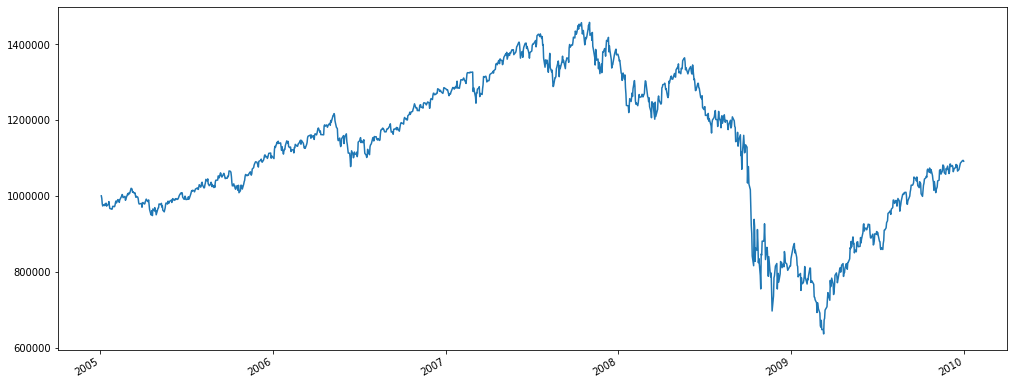

In [107]:
bl_spo_results[0].v.plot(figsize=(17,7))

In [108]:
bl_spo_results[0].profit

91301.22325387795

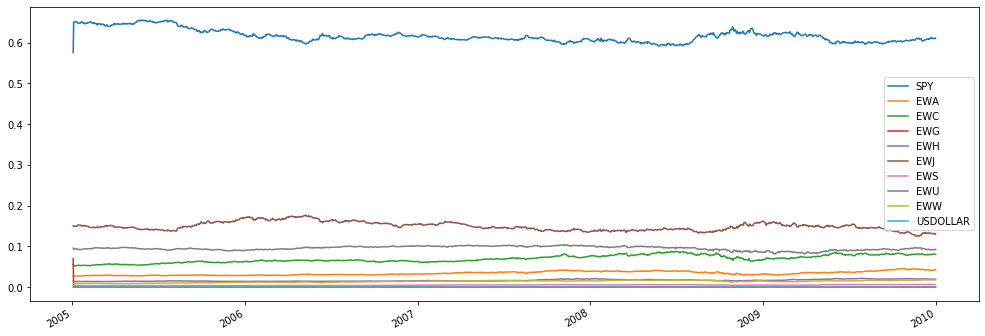

In [109]:
bl_spo_results[0].w.plot(figsize=(17,6))